<a id="top"></a>
# Sentinel-1 Data Analysis Notebook

<hr>

# Notebook Summary

This notebook visualizes and analyzes Sentinel-1 data.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load and Clean Data from the Data Cube](#load_data)
* [Show Acquisition Times](#show_acq_times)
* [Single Date Analyses](#single_date_analyses)
    * [Histogram Plots](#histograms)
    * [Scaling of Backscatter Amplitude for Images](#scaling)
    * [RGB Images](#rgb)
    * [Custom RGB](#custom_rgb)
    * [Single Date Threshold Product](#single_threshold)
* [Time Series Analyses](#time_series_analyses)
    * [Box-and-Whisker and Gaussian Plots](#box_whisker_gaussian_plots)
    * [Time Series Statistics Filter](#stats_filter)
    * [Multi-Date Change Product](#change_product)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
%matplotlib inline
# Ignore warnings (from NDVI)
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import matplotlib
# Set a legible font size for matplotlib plots.
plt.rcParams.update({'font.size': 16})

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_invalid
from utils.data_cube_utilities.dc_rgb import rgb
import numpy as np
import xarray as xr
import pandas as pd

from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from matplotlib.colors import LinearSegmentedColormap

# Create an instance of the datacube and API.
api = DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

In [2]:
# These are the SAR platforms (satellites) and 
# products (datacube sets) used for this demonstration.
platforms = ['SENTINEL1']
products = ['s1monthly_gamma0_ghana']

# The fraction of the original resolution to use for analysis.
# Use this to control memory consumption and run time.
# Set this to None to not scale the resolution of the data.
frac_res = None

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [3]:
from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

# Print the extents of each product.
str_min_max_dates = np.vectorize(dt_to_str)(min_max_dates)
for i, (platform, product) in enumerate(zip(platforms, products)):
    print("For platform {} and product {}:".format(platform, product))
    print("Time Extents:", str_min_max_dates[i])
    print()

# Print the extents of the combined data.
min_start_date_mutual = np.max(min_max_dates[:,0])
max_end_date_mutual = np.min(min_max_dates[:,1])
print("Overlapping Extents:")
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_start_date_mutual, max_end_date_mutual))))

For platform SENTINEL1 and product s1monthly_gamma0_ghana:
Time Extents: ['2015-03-15' '2018-10-15']

Overlapping Extents:
Latitude Extents: (4.690863952, 11.289762652)
Longitude Extents: (-3.36674818, 1.3938536199999998)
Time Extents: ['2015-03-15', '2018-10-15']


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [4]:
# Specify latitude and longitude bounds of an interesting area within the full extents.
# shown in the metadata report above (reduce area for faster processing times).

# Mining in Kibi, Ghana (N6.16789 W0.54533) 
# increased vegetation from Jan 2017 to Dec 2018
# lat = (6.166, 6.175)
# lon = (-0.548, -0.539)

## Mining in Asikam, Ghana (N6.20339 W0.53754)
# lat = (6.190, 6.209) 
# lon = (-0.548, -0.530)

# Mining region west of Obuasi, Ghana
lat = (6.2286, 6.2822)
lon = (-1.9324, -1.8871)

# Water Demo for Mining
# lat = (6.2407, 6.2444)
# lon = (-1.9025, -1.8993)

# Mining Area - Deforestation Example
# lat = (6.2485, 6.2575)
# lon = (-1.8908, -1.8808)

# Kumasi City (large region)
#lat = (6.5719, 6.8420 )
#lon = (-1.7538, -1.4558)

# Barekese Dam
# lat = (6.8201, 6.8688)
# lon = (-1.7476, -1.6780)

# Okosombo - Volta River (diverse region)
# lat = (6.2546, 6.3226)
# lon = (0.0271, 0.0975)

# Volta Region Mangroves
#lat = (5.7666, 5.9425)
#lon = (0.5546, 0.8175)

# Densu Delta Ramsar Site
#lat = (5.505, 5.572)
#lon = (-0.330, -0.268)

# Nyankpala agricultural area near Tamale, Ghana
# Large seasonal variation in backscatter (>6dB) 
# lat = (9.35, 9.45)
# lon = (-1.05, -0.95)

# Central Ghana near Obuasi
# lat = (6.00, 6.13)
# lon = (-2.03, -1.86)

# Time Period
# Sentinel-1 data for Ghana is monthly and has a date tag of the 15th day in each month
time_extents = ('2015-03-01', '2018-11-01')

**Visualize the selected area**

In [5]:
display_map(lat, lon)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>

In [6]:
from utils.data_cube_utilities.dc_load import reduce_on_day, match_dim_sizes
from utils.data_cube_utilities.sort import xarray_sortby_coord
from utils.data_cube_utilities.aggregate import xr_scale_res

def get_s1_dataset(dc, platforms, products, **load_params):
    """
    Loads a Sentinel-1 dataset with specified platforms and products.
    
    Parameters
    ----------
    dc: datacube.Datacube
        The connection to the Data Cube to load data with.
    platforms, products: list of str
        The lists of platforms and products to load data from.
        Must be the same length.
    **load_params: dict
        Kyword arguments to be passed to `dc.load()`.
        Should include lat, lon, time, and measurements.
    
    Returns
    -------
    sar_dataset: xarray.Dataset
        The Sentinel-1 data requested.
    sar_clean_mask: xarray.DataArray
        The boolean clean mask specifying what values are "clean".
    """
    sar_datasets = {}
    sar_clean_masks = {}
    lat, lon = load_params.pop('lat'), load_params.pop('lon')
    matching_abs_res, same_dim_sizes = match_dim_sizes(dc, products, lon, lat, method='min')
    for platform, product in zip(platforms, products):
        # Load the data.
        dataset = dc.load(platform=platform, product=product, lat=lat, lon=lon, **load_params)
        if len(dataset.dims) == 0: # The dataset is empty.
            continue
        sar_datasets[product] = dataset
        # Get the clean masks.
        sar_clean_masks[product] = (sar_datasets[product].vv != 0).astype(np.uint8)
        # Combine multiple acquisitions in the same day.
        sar_datasets[product] = reduce_on_day(sar_datasets[product])
        sar_clean_masks[product] = reduce_on_day(sar_clean_masks[product].to_dataset('clean_mask'))['clean_mask']
        # If needed, scale the datasets and clean masks to the same size in the x and y dimensions.
        if not same_dim_sizes:    
            sar_datasets[product] = xr_scale_res(sar_datasets[product], abs_res=matching_abs_res)
            sar_clean_masks[product] = xr_scale_res(sar_clean_masks[product], abs_res=matching_abs_res).astype(np.bool)
        # Clean the data.
        sar_datasets[product].update(sar_datasets[product].where(sar_clean_masks[product], np.nan))
    # Combine everything.
    if len(sar_datasets) > 0:
        sar_dataset = xarray_sortby_coord(xr.concat(list(sar_datasets.values()), dim='time'), coord='time')
        sar_clean_mask = xarray_sortby_coord(xr.concat(list(sar_clean_masks.values()), dim='time'), coord='time')
        # Combine multiple acquisitions in the same day for the combined data.
        sar_dataset = reduce_on_day(sar_dataset)
        sar_clean_mask = reduce_on_day(sar_clean_mask.to_dataset('clean_mask'))['clean_mask']
    else:
        sar_dataset = xr.Dataset()
        sar_clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
    return sar_dataset, sar_clean_mask

In [7]:
sar_dataset, sar_clean_mask = \
    get_s1_dataset(dc, platforms, products, lat=lat, lon=lon, 
                   time=time_extents, measurements=['vv', 'vh'])

**Perform noise reduction since SAR data is usually very noisy.**
<br>Note that this can take a while. Remove the comments to run this code.
<br>The filter size refers to the number of pixels used in the averaging window.
<br>Filter sizes should be odd, such as 3 (for 3x3), 5, 7, etc.

In [8]:
from utils.data_cube_utilities.raster_filter import stats_filter_2d

# for time in sar_dataset.time:
#      for data_var in sar_dataset:
#         data_arr = sar_dataset.sel(time=time)[data_var]
#         data_arr.values[:] = stats_filter_2d(data_arr, 'mean', filter_size=3).values

In [9]:
# Creation of a new band (VV/VH = vvvh) for histogram evaluation
sar_dataset['vvvh'] = sar_dataset.vv / sar_dataset.vh

## <span id="show_acq_times">Show Acquisition Times [&#9652;](#top)</span>

In [10]:
from utils.data_cube_utilities.dc_time import _n64_to_datetime
from utils.data_cube_utilities.plotter_utils import month_names_long
def n64_to_month_and_year(n64):
    datetime_val = _n64_to_datetime(n64)
    return month_names_long[datetime_val.month-1] + ' ' + str(datetime_val.year)

In [11]:
# Show acquisition indices and times.
print("Available acquisition indices and times")
times = sar_dataset.time.values
months = np.array(list(map(n64_to_month_and_year, times)))
pd.DataFrame(dict(times=times, months=months))

Available acquisition indices and times


,times,months
0,2015-03-15,March 2015
1,2015-04-15,April 2015
2,2015-05-15,May 2015
3,2015-06-15,June 2015
4,2015-07-15,July 2015
5,2015-08-15,August 2015
6,2015-09-15,September 2015
7,2015-10-15,October 2015
8,2015-11-15,November 2015
9,2015-12-15,December 2015


## <span id="single_date_analyses">Single Date Analyses [&#9652;](#top)</span>

In [12]:
# Choose a single acquisition by its index (listed above)
acq_ind_to_show = 23

### <span id="histograms">Histogram Plots [&#9652;](#top)</span>

In [13]:
from xarray.ufuncs import isfinite

# Determine a range of values to limit the x axis to for histogram plots.
# This allows the histograms to be more easily compared.
# Use quantiles to avoid extreme outliers.

# hist_ds = sar_dataset.isel(time=acq_ind_to_show)[['vv','vh','vvvh']]
hist_ds = sar_dataset.isel(time=acq_ind_to_show)[['vv','vh']]
hist_ds = hist_ds.where(isfinite(hist_ds))

min_per_data_var = hist_ds.quantile(0.001).to_array().values
min_val = min_per_data_var[np.isfinite(min_per_data_var)].min()

max_per_data_var = hist_ds.quantile(0.999).to_array().values
max_val = max_per_data_var[np.isfinite(max_per_data_var)].max()

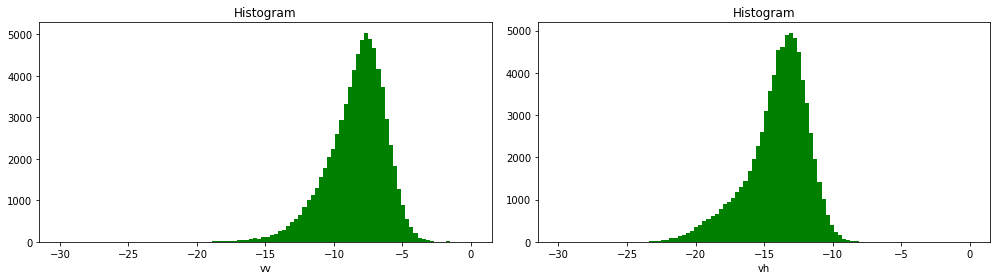

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

sar_dataset.isel(time=acq_ind_to_show).vv.plot.hist(ax=ax[0], bins=100, range=(-30,0), facecolor='green')
sar_dataset.isel(time=acq_ind_to_show).vh.plot.hist(ax=ax[1], bins=100, range=(-30,0), facecolor='green')

plt.tight_layout()
plt.show()

### <span id="scaling">Scaling of Backscatter Amplitude for Images [&#9652;](#top)</span>

</b> Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in VV and VH image products. This process is explained here. Gamma-nought backscatter amplitude (in dB units) can be converted to raw (digital number) units using the conversion: DN (amplitude) = 10^(dB/20). Histograms are then used to view the range of dB values for the VV and VH bands. The range of expected values (across diverse land types) is then scaled to an 8-bit range using the formula: Scale = 256 / (range). Finally, an "offset" value is applied to allow the full range of values to be distributed across the 8-bit range. The final equation is: DN (amplitude, 8-bit) = ( DN(amplitude) - offset ) * scale. 

In [15]:
sar_dataset['vv_amp_8b'] = (10**(sar_dataset.vv/20)-.1)*400
sar_dataset['vh_amp_8b'] = (10**(sar_dataset.vh/20)-.06)*750
sar_dataset['vvvh_amp_8b'] = (((10**(sar_dataset.vv/20)-.1)*400) / ((10**(sar_dataset.vh/20)-.06)*750)) * 100-25

### <span id="rgb">RGB Images [&#9652;](#top)</span>

(<Figure size 1008x849.02 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71e2d64390>)

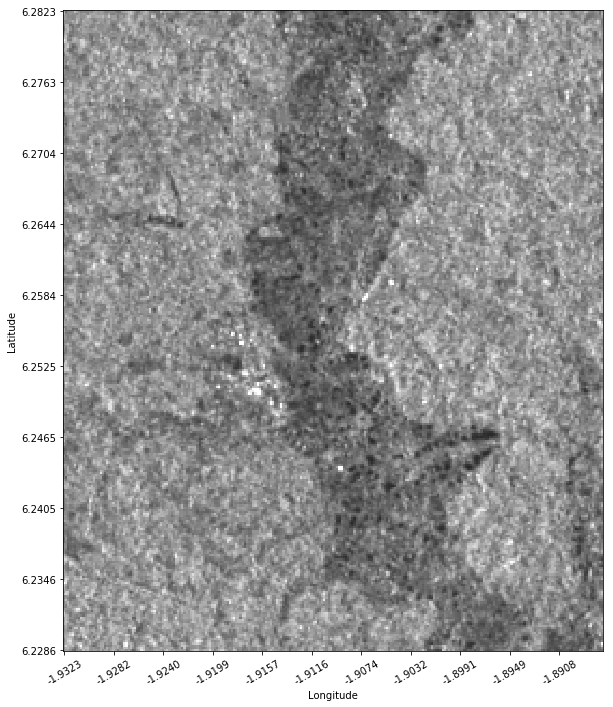

In [16]:
# Scaled VV image
rgb(sar_dataset.isel(time=acq_ind_to_show), 
    bands=['vv_amp_8b','vv_amp_8b','vv_amp_8b'], min_possible=0, max_possible=255, width=14)

(<Figure size 1008x849.02 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71dadb8898>)

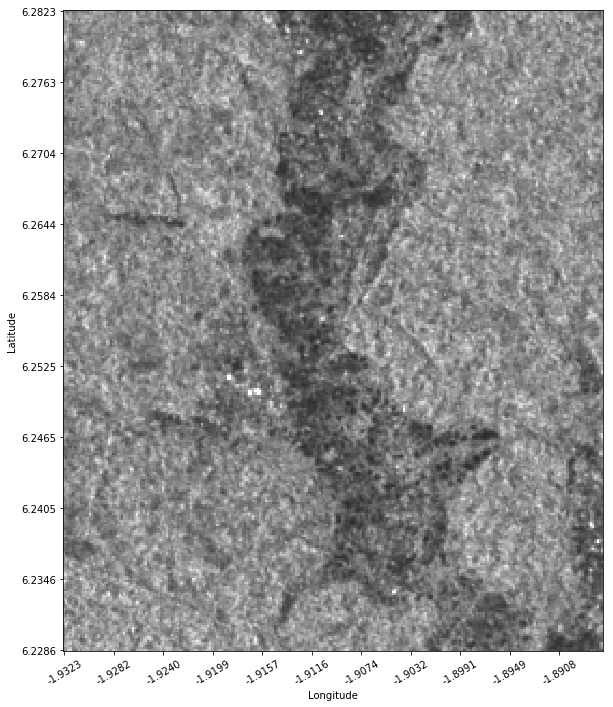

In [17]:
# Scaled VH image
rgb(sar_dataset.isel(time=acq_ind_to_show), 
    bands=['vh_amp_8b','vh_amp_8b','vh_amp_8b'], min_possible=0, max_possible=255, width=14)

(<Figure size 1008x849.02 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71dadac2e8>)

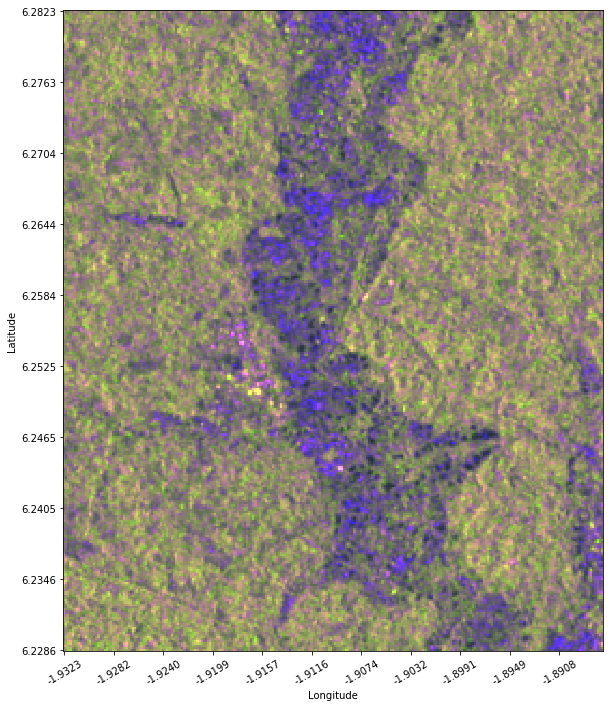

In [18]:
# Scaled RGB (VV, VH, VV/VH)
rgb(sar_dataset.isel(time=acq_ind_to_show), 
    bands=['vv_amp_8b','vh_amp_8b','vvvh_amp_8b'], min_possible = 0, max_possible = 255, width=14)

### <span id="custom_rgb">Custom RGB [&#9652;](#top)</span>
Select the image number and band for each RGB color

In [19]:
from utils.data_cube_utilities.dc_time import _n64_to_datetime
from utils.data_cube_utilities.plotter_utils import figure_ratio, retrieve_or_create_fig_ax

def custom_rgb(dataset, rgb_to_data_arr_ind_map, **rgb_kwargs):
    """
    Plots many images with a mapping of the red, green, and blue channels to data variables and
    time indices in an `xarray.Dataset`.
    
    Parameters
    ----------
    dataset: xarray.Dataset
        The dataset containing all data variables mentioned in `rgb_to_data_arr_ind_map`.
        Must have a 'time' dimension.
    rgb_to_data_arr_ind_map: list-like of list-like of int and string
        A sequence of 3 sequences of 2 elements of time indices and data variables in `dataset` 
        to use as the red, green, and blue channels, respectively.
        For example, [['nir', 0], ['swir1', 1], ['swir2', 2]] makes the red channel 
        the 'nir' data variable in time 0, the green channel the 'swir1' data variable in time 1, 
        and the green channel the 'swir2' data variable in time 2.
    **rgb_kwargs: dict
        Keyword arguments to pass to `utils.data_cube_utilities.dc_rgb.rgb()`.
    
    Returns
    -------
    fig, ax: matplotlib.figure.Figure, matplotlib.axes.Axes
        The matplotlib figure and axes used to make the plot grid.
    """
    # Obtain the data to plot.
    rgb_data = {}
    for channel, [data_var, time_ind] in zip(['red', 'green', 'blue'], rgb_to_data_arr_ind_map):
        rgb_data[channel] = dataset[data_var].isel(time=time_ind)
        rgb_data[channel] = rgb_data[channel].drop('time')
    rgb_data = xr.Dataset(rgb_data)
    rgb_kwargs['dataset'] = rgb_data
    
    rgb(**rgb_kwargs)
    
    return fig, ax

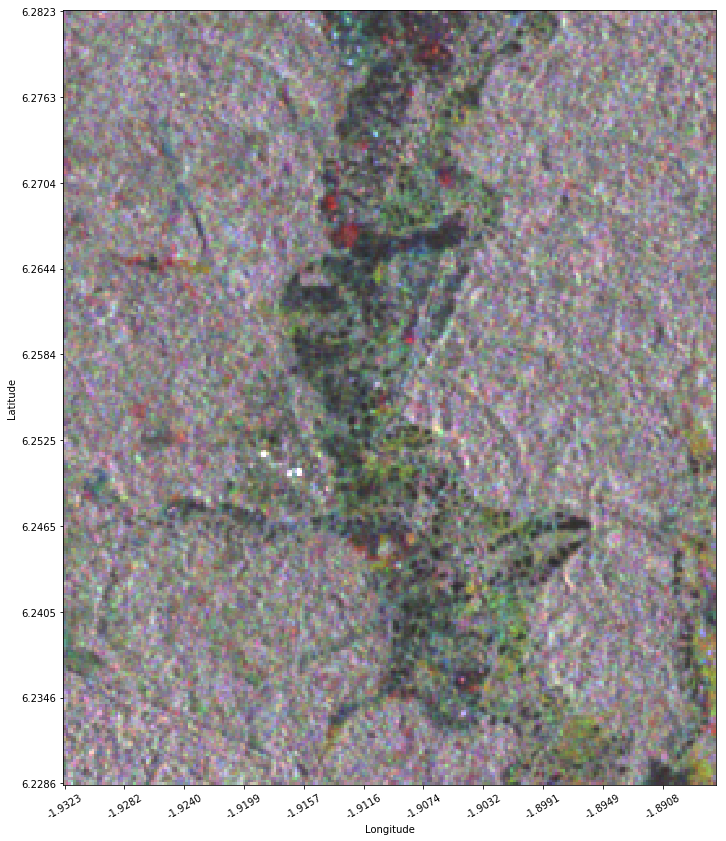

In [20]:
# Custom RGB logic
# Select the band and scene index for each color, RGB, in order

rgb_to_data_arr_ind_map = [['vh_amp_8b', 12], ['vh_amp_8b', 17], ['vh_amp_8b', 23]]
custom_rgb(sar_dataset, rgb_to_data_arr_ind_map, min_possible=0, max_possible=255, width=14)
plt.tight_layout()
plt.show()

### <span id="single_threshold">Single Date Threshold Product [&#9652;](#top)</span>

In [21]:
# Select the single acquisition to use for threshold plot
# Choose from the indices in the table above

acq_ind_to_show = 11

# Select the variable to plot: vv, vh, or vvvh

threshold_data_var = 'vv'

# Select the minimum and maximum values of the threshold range.
# Below the low limit = BLUE
# Above the high limit = RED

threshold_range = (-12, 5)

In [22]:
def plot_threshold(ds, band_name, bottom = None , top = None, log_scaled = False, 
                   cmap_name = 'Greys', fig=None, ax=None):
    # Threshold is applied to original data, not log scaled data(if you haven't scaled already)
    _range = "Full {} range: {}-{}".format(band_name, ds[band_name].min().values,ds[band_name].max().values)

    selection = ds[band_name]
    
    my_cmap = matplotlib.cm.get_cmap(cmap_name)
    my_cmap.set_over('r')
    my_cmap.set_under('b')
    
    fig, ax = retrieve_or_create_fig_ax(fig, ax)
    
    selection = 10*np.log10(selection) if log_scaled == True else selection
    
    bottom    = 10*np.log10(bottom)    if log_scaled == True and bottom is not None else bottom
    top       = 10*np.log10(top)       if log_scaled == True and top is not None else top
    
    selection.plot(cmap = my_cmap, vmax =top, vmin = bottom, ax=ax)    
    xlim, ylim = ax.set_xlim(), ax.set_ylim()
    ax.text(min(xlim) + 0.5 * (max(xlim) - min(xlim)),
            min(ylim) + -0.1 * (max(ylim) - min(ylim)),_range, horizontalalignment = "center")

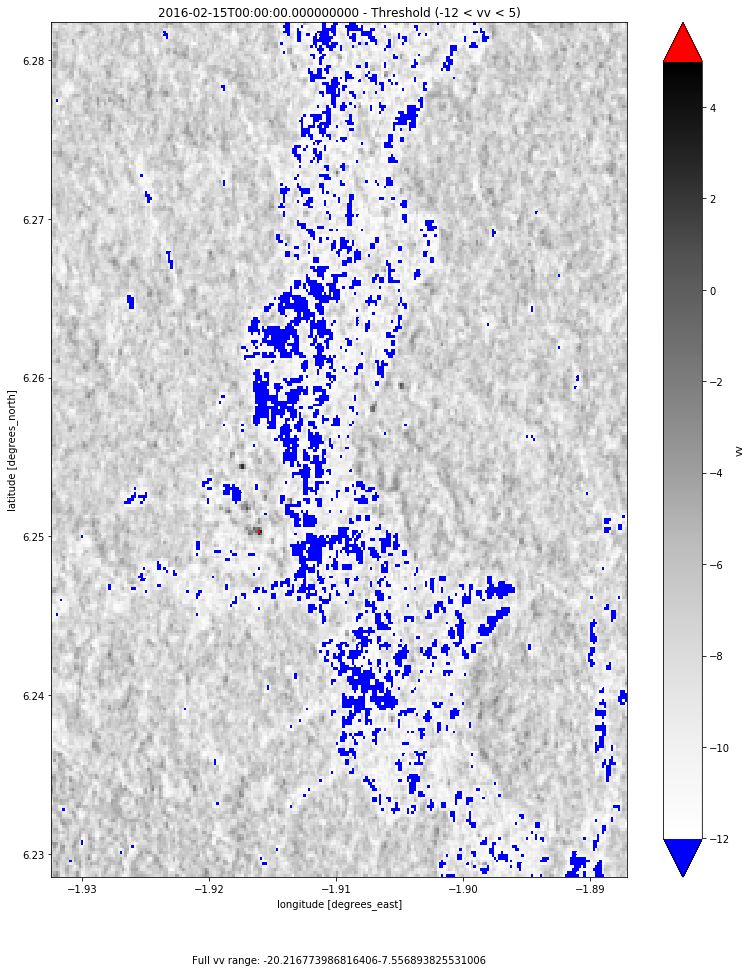

In [23]:
## Threshold Plot Settings ##

assert threshold_data_var in ['vv', 'vh', 'vvvh'], \
    "The variable `threshold_data_var` must be one of 'vv', 'vh', or 'vvvh'."

# Set the size of the figure.
figsize = figure_ratio(sar_dataset.isel(time=acq_ind_to_show), fixed_width=10)
## End Settings ##

# acq_data = sar_dataset.isel(time=acq_ind_to_show)
# if threshold_data_var == 'vvvh':
#     acq_data['vvvh'] = acq_data.vv / acq_data.vh
fig = plt.figure(figsize=figsize)
bottom, top = threshold_range
plot_threshold(sar_dataset.isel(time=acq_ind_to_show), 
               threshold_data_var, bottom=bottom, top=top, fig=fig)
plt.title(str(sar_dataset.isel(time=acq_ind_to_show).time.values) + 
          " - Threshold ({} < {} < {})".format(bottom, threshold_data_var, top))
plt.show()

## <span id="time_series_analyses">Time Series Analyses [&#9652;](#top)</span>

### <span id="box_whisker_gaussian_plots">Box-and-Whisker and Gaussian Plots [&#9652;](#top)</span>

In [24]:
# Select the range of acquisitions to use for the time series plots
# Choose from the indices in the table above
# The lower bound is inclusive. The upper bound is exclusive

acq_ind_ranges = [(0, 23)]

# Select the variable to plot in the time series analyses
# Choose vv, vh, or vvvh

data_var_to_plot = 'vh'

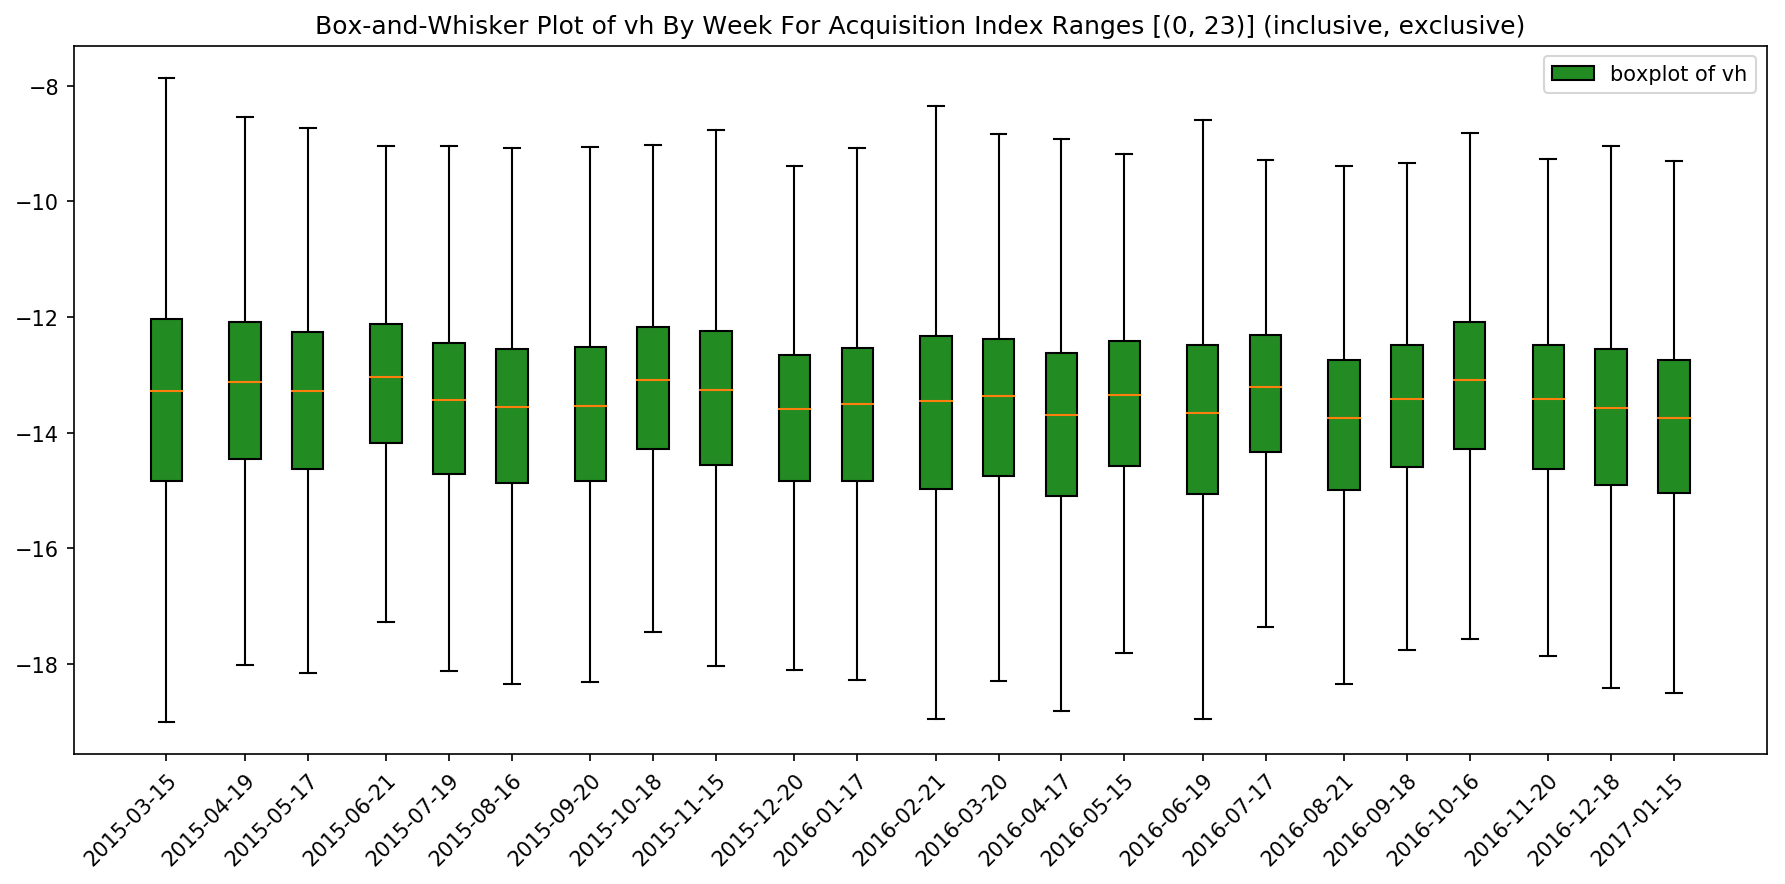

In [25]:
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

# Plotting Settings #

for i, acq_ind_range in enumerate(acq_ind_ranges):
    assert acq_ind_range[0] >= 0 and acq_ind_range[1] > 0, \
        "Indices in `acq_ind_ranges` must be positive (see index {}).".format(i)
    assert acq_ind_range[1] > acq_ind_range[0], \
        "The second value in each pair of acquisition indices must be" \
         "greater than the first value (see index {}).".format(i)

assert data_var_to_plot in list(sar_dataset.data_vars.keys()), \
    "The variable `data_var_to_plot` must be one of {}.".format(list(sar_dataset.data_vars.keys()))

# Select the binning approach for the vegetation index. Set the 'bin_by' parameter.
# None          = do not bin the data
# 'week'        = bin the data by week with an extended time axis
# 'month'       = bin the data by month with an extended time axis
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis
bin_by = 'week'
assert bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear'], \
    "The variable 'bin_by' can only have one of these values: "\
    "[None, 'week', 'month', 'weekofyear', 'monthofyear']"

# The maximum number of time slices for which data is plotted in a given plot grid cell.
max_times_per_plot=50

## End Settings ##

# Format `acq_ind_ranges` for xarray `isel()` and select the acquisitions.
acq_inds = np.concatenate([np.arange(*acq_ind_range) 
                           for acq_ind_range in acq_ind_ranges])
plotting_data = sar_dataset.isel(time=acq_inds)

aggregated_by_str = ''
if bin_by is None:
    plotting_data = plotting_data
elif bin_by == 'week':
    plotting_data = plotting_data.resample(time='1w').mean()
    aggregated_by_str = 'By Week'
elif bin_by == 'month':
    plotting_data = plotting_data.resample(time='1m').mean()
    aggregated_by_str = 'By Month'
elif bin_by == 'weekofyear':
    plotting_data = plotting_data.groupby('time.week').mean(dim=('time'))
    aggregated_by_str = 'By Week of Year'
elif bin_by == 'monthofyear':
    plotting_data = plotting_data.groupby('time.month').mean(dim=('time'))
    aggregated_by_str = 'By Month of Year'


params = dict(dataset=plotting_data, 
              plot_descs={data_var_to_plot:{
                  'none':[{'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})

xarray_time_series_plot(**params, fig_params=dict(figsize=(12,6), dpi=150), 
                        max_times_per_plot=max_times_per_plot)
plt.title('Box-and-Whisker Plot of {} {} For Acquisition Index Ranges {} (inclusive, exclusive)'
          .format(data_var_to_plot, aggregated_by_str, acq_ind_ranges))
plt.show()

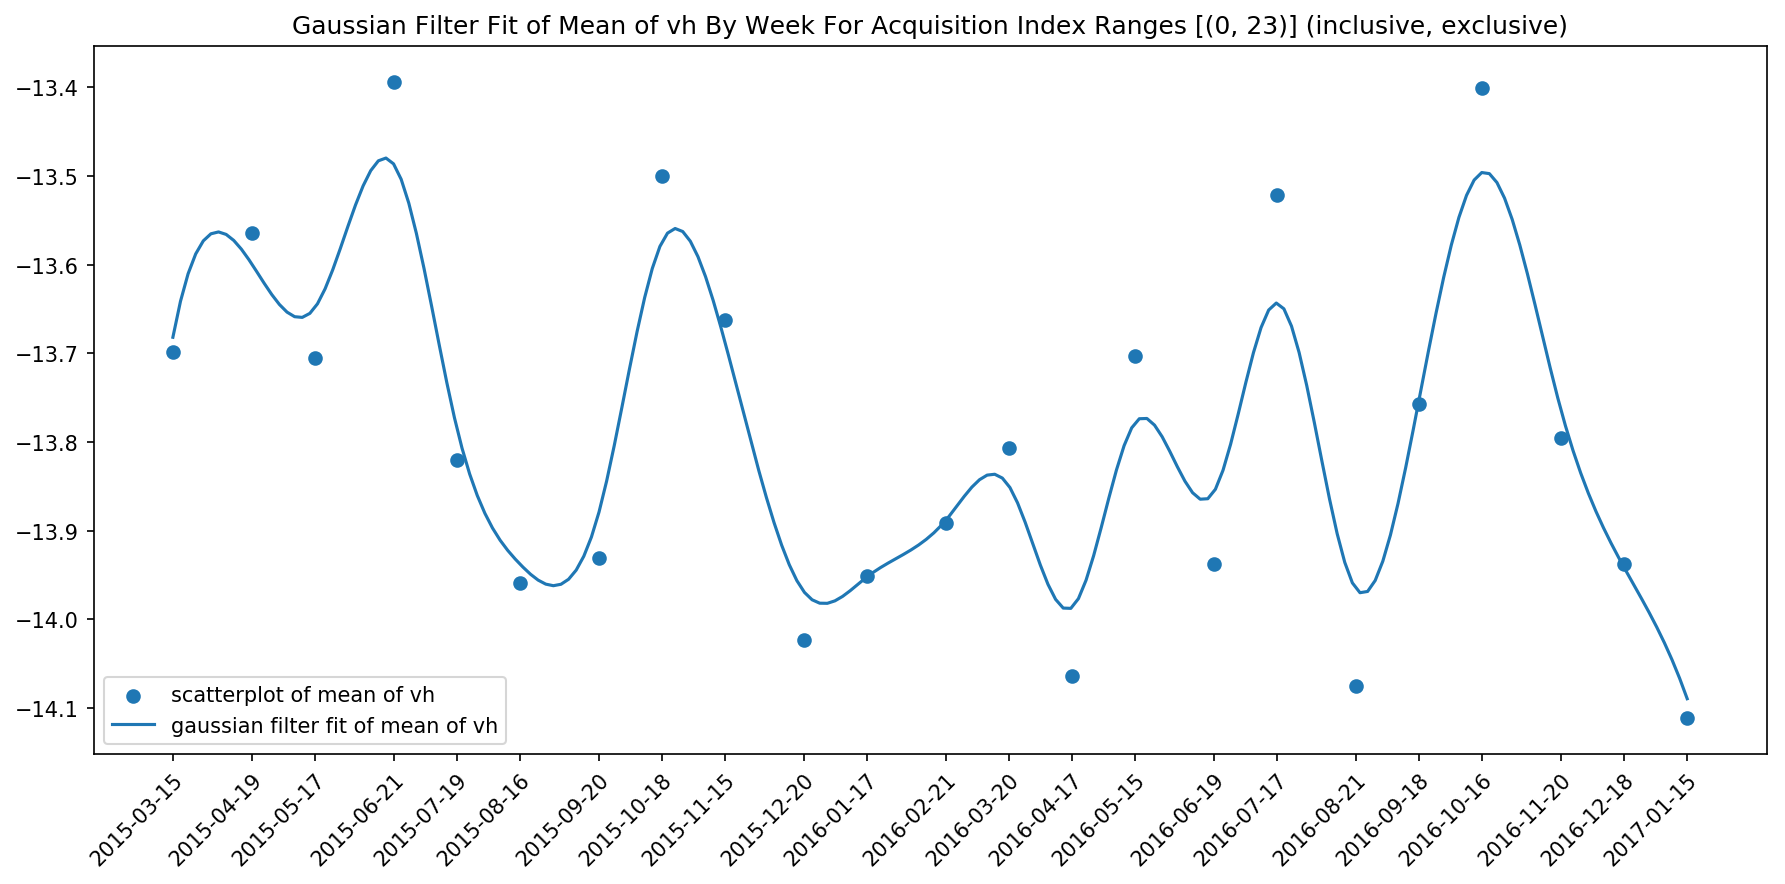

In [26]:
data_var_std_dev = plotting_data[data_var_to_plot].std().values
params = dict(dataset=plotting_data, 
              plot_descs={data_var_to_plot:{
                  'mean':[{'scatter':{}},
                          {'gaussian_filter':{'sigma': (1/4)*data_var_std_dev}}]}})
xarray_time_series_plot(**params, fig_params=dict(figsize=(12,6), dpi=150), 
                        max_times_per_plot=max_times_per_plot)
plt.title('Gaussian Filter Fit of Mean of {} {} For Acquisition Index Ranges {} ' 
          '(inclusive, exclusive)'.format(data_var_to_plot, aggregated_by_str, acq_ind_ranges))
plt.show()

### <span id="stats_filter">Time Series Statistics Filter [&#9652;](#top)</span>

In [27]:
def stats_filter(dataarray, statistic, filter_shape=(1,1)):
    """
    Returns a mean, median, or standard deviation filter of an `xarray.DataArray`.
    This function is more accurate than using SciPy or scikit-image methods, because
    those don't handle the extremities ideally. Specifically, only values actually 
    inside the filter should be considered, so the data is padded with NaNs.
    This function is resilient to NaNs in the data.
    
    Parameters
    ----------
    dataarray: xarray.DataArray
        The data to create a filtered version of. Must have 3 dimensions, with
        the last being 'time'.
    statistic: string
        The name of the statistic to use for the filter.
        The possible values are ['mean', 'median', 'std'].
    filter_shape: list-like of 2 odd, positive integers
        The shape of the filter to use. Both dimensions should have odd lengths.
    """
    filter_dims = dataarray.dims[:2]
    filter_coords = {dim: dataarray.coords[dim] for dim in filter_dims}
    filter_output = xr.DataArray(np.full(dataarray.shape[:2], np.nan), 
                                 coords=filter_coords, dims=filter_dims)
    if filter_shape == (1,1):
        agg_func_kwargs = dict(a=dataarray.values, axis=dataarray.get_axis_num('time'))
        if statistic == 'mean':
            filter_output.values[:] = np.nanmean(**agg_func_kwargs)
        elif statistic == 'median':
            filter_output.values[:] = np.nanmedian(**agg_func_kwargs)
        elif statistic == 'std':
            filter_output.values[:] = np.nanstd(**agg_func_kwargs)
    else:
        # Allocate a Numpy array containing the content of `dataarray`, but padded 
        # with NaNs to ensure the statistics are correct at the x and y extremeties of the data.
        flt_shp = np.array(filter_shape)
        del filter_shape
        shp = np.array(dataarray.shape[:2])
        pad_shp = (*(shp + flt_shp - 1), dataarray.shape[2])
        padding = (flt_shp-1)//2 # The number of NaNs from an edge of the padding to the data.
        padded_arr = np.full(pad_shp, np.nan)
        padded_arr[padding[0]:pad_shp[0]-padding[0], 
                   padding[1]:pad_shp[1]-padding[1]] = dataarray.values

        # For each point in the first two dimensions of `dataarray`...
        for i in range(filter_output.shape[0]):
            for j in range(filter_output.shape[1]):
                padded_arr_segment = padded_arr[i:i+flt_shp[0],
                                                j:j+flt_shp[1]]
                if statistic == 'mean':
                    filter_output.values[i,j] = np.nanmean(padded_arr_segment)
                elif statistic == 'median':
                    filter_output.values[i,j] = np.nanmedian(padded_arr_segment)
                elif statistic == 'std':
                    filter_output.values[i,j] = np.nanstd(padded_arr_segment)
    
    return filter_output

In [28]:
# Choose the acquisition range by their indices and then apply statistics
# The lower bound is inclusive. The upper bound is exclusive.

# Mean VH for year 2018 (example)
acq_ind_ranges = [(0, 23)]

# The `xarray.DataArray` member of `sar_dataset` to calculate statistics for.
stats_data_arr = 'vh'

# Format `acq_ind_ranges` for xarray `isel()` and select the acquisitions.
acq_ind_ranges = np.concatenate([np.arange(*acq_ind_range) 
                                 for acq_ind_range in acq_ind_ranges])
stats_data = sar_dataset[stats_data_arr].isel(time=acq_ind_ranges)\
             .transpose('latitude', 'longitude', 'time')
vmin, vmax = stats_data.min().values, stats_data.max().values

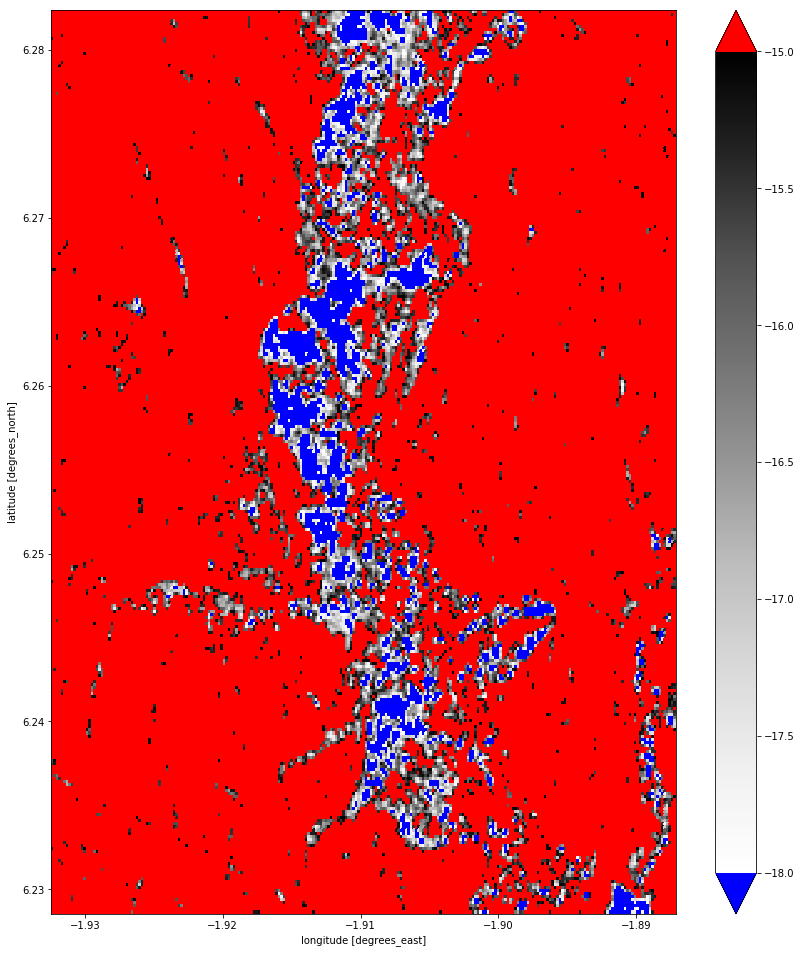

In [29]:
# Select filter type: mean, median, std
# Select the filter shape (odd integer, odd integer)

mean_filtered_sar = stats_filter(stats_data, 'mean')

figsize = figure_ratio(sar_dataset.isel(time=acq_ind_to_show), fixed_width=14)
plt.figure(figsize=figsize)
mean_filtered_sar.plot(cmap='Greys', vmin=-18, vmax=-15)
plt.show()

### <span id="change_product">Multi-Date Change Product [&#9652;](#top)</span>

In [30]:
# Select TWO acquisitions to calculate a change product
# Choose from the indices in the table above

# Compare two time slices

first_acq_ind = 11
second_acq_ind = 23


# Select the variable to plot: vv, vh, or vvvh

threshold_data_var = 'vh'

# The code will calculate the difference of the two images (Second-First)
# Define a threshold range to compare the difference of the two acquisitions
# GREY = Pixels NOT in the threshold range 
# RED = Pixels LESS than the low end of the threshold range
# GREEN = Pixels MORE than the high end of the threshold range
threshold_range = (-3, 2)

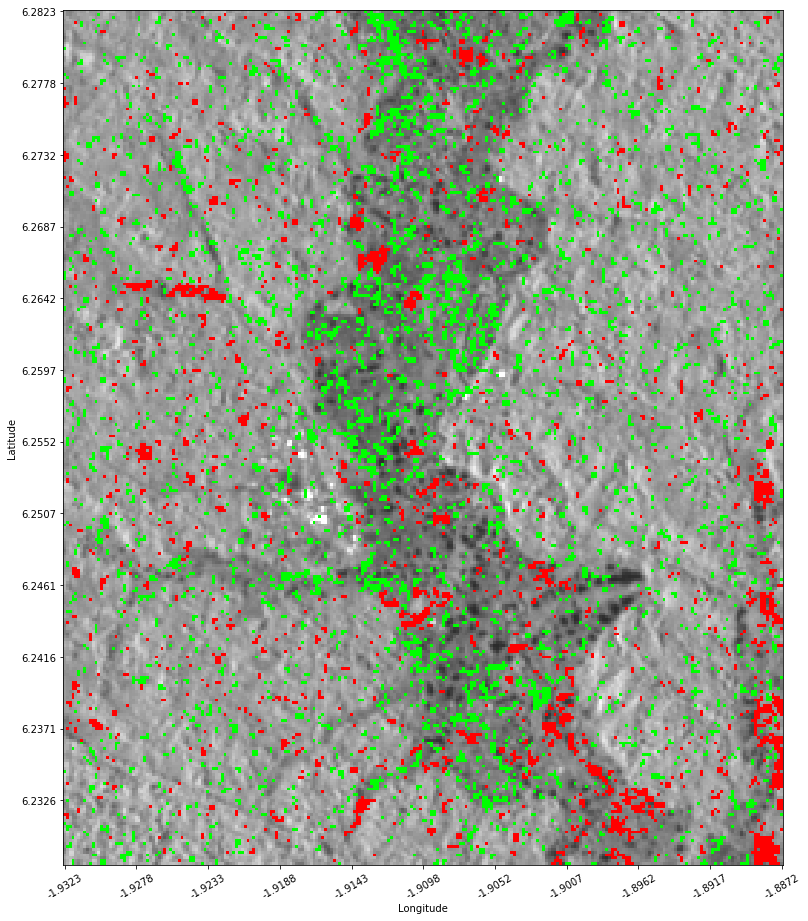

In [31]:
from utils.data_cube_utilities.plotter_utils import intersection_threshold_plot
from xarray.ufuncs import fabs

assert first_acq_ind >= 0 and second_acq_ind > 0, \
    "The variables `first_acq_ind` and `second_acq_ind` must be positive."
assert second_acq_ind > first_acq_ind, \
    "The variable `second_acq_ind` must be greater than `first_acq_ind`."
assert threshold_data_var in list(sar_dataset.data_vars.keys()), \
    "The variable `threshold_data_var` must be one of {}.".format(list(sar_dataset.data_vars.keys()))

## Change Product Settings ##

color_loss = np.array([255,0,0]) # backscatter decrease (RED)
color_gain = np.array([0,255,0]) # backscatter increase (GREEN)

# Set the size of the figure.
figsize = figure_ratio(sar_dataset.isel(time=acq_ind_to_show), fixed_width=10)
## End Settings ##

fig = plt.figure(figsize=figsize)

first_acq = sar_dataset.isel(time=first_acq_ind)
second_acq = sar_dataset.isel(time=second_acq_ind)

sar_composite = sar_dataset.median('time')
change_product = second_acq[threshold_data_var] - first_acq[threshold_data_var]

below_th = change_product.values < threshold_range[0]
change_in_th = (threshold_range[0] < change_product.values) & \
               (change_product.values < threshold_range[1])
above_th = threshold_range[1] < change_product.values

rgb(sar_composite, bands=['vv_amp_8b', 'vv_amp_8b', 'vv_amp_8b'], min_possible=0, max_possible=255, 
    paint_on_mask=[(below_th, color_loss), (above_th, color_gain)], fig=fig)

plt.show()

In [32]:
num_px_below = (change_product < threshold_range[0]).sum().values
print("Pixels below the threshold range: {} ({:.2%})".format( 
      num_px_below, num_px_below/change_product.size))
num_px_in = change_in_th.sum()
print("Pixels within the threshold range: {} ({:.2%})".format(
      num_px_in, num_px_in/change_product.size))
num_px_above = (threshold_range[1] < change_product).sum().values
print("Pixels above the threshold range: {} ({:.2%})".format(
      num_px_above, num_px_above/change_product.size))

Pixels below the threshold range: 2955 (3.95%)
Pixels within the threshold range: 65990 (88.22%)
Pixels above the threshold range: 5853 (7.83%)
